In [1]:
import numpy
from matplotlib import pyplot

# Imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import TimeSeries
from pyfoomb import Helpers

Could not find GLIMDA.


Current package version of pyfoomb: 2.17.0


# 1. Example: Simple growth model

Implements a simple exponential growth model, with the specific growth rate described by the well-known Monod equation.

### Model equations
$$
\begin{align}
    \mu &= \mu_{max} \frac{c_S}{c_S + k_S}\\
    \frac{dc_X}{dt} &= \mu \cdot c_X & c_X(t_0) = c_{X,0}\\
    \frac{dc_S}{dt} &= -\frac{1}{Y_{X/S}} \cdot \frac{dc_X}{dt}  & c_S(t_0) = c_{S,0}\\
\end{align}
$$

### Parametrization
$$
\mathbf{\theta} = \left[ k_S \; \mu_{max} \; Y_{X/S} \; c_{S,0} \; c_{X,0}\right]^T
$$

In [2]:
# Defines the model class
class BatchGrowth(BioprocessModel):
    
    # The Monod equation is defined as classmethod
    @classmethod
    def Monod(cls, S, mu_max, kS):
        return mu_max * S / (kS + S)
        
    
    def rhs(self, t, y):
        
        # Unpacks the state vector. The states are alphabetically case-insensitive ordered.
        S, X = y
        
        # Unpacks the model parameters.
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        YXS = self.model_parameters['YXS']
        
        # Calculate the current growth rate
        mu = self.Monod(S, mu_max, kS)
        
        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -1/YXS * dXdt
        
        return [dSdt, dXdt]

    
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.5,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
}
        
caretaker = Caretaker(
    bioprocess_model_class=BatchGrowth, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

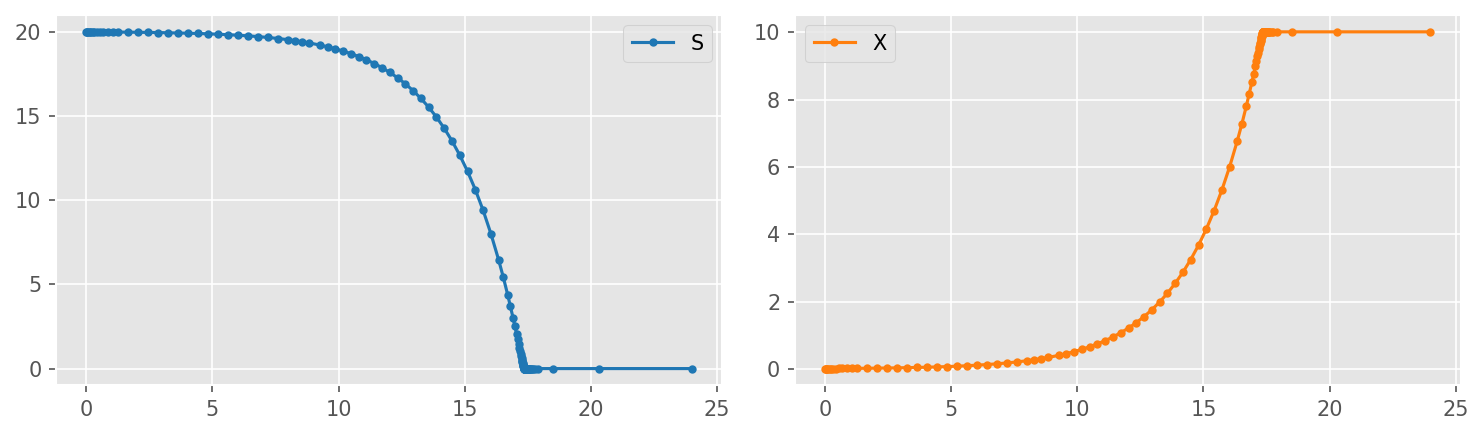

In [3]:
simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation, ncols=2)

# 2. Example: Simple growth with product formation

Extends the first example by product formation, which is modelled as purely growth coupled.

### Model equations
$$
\begin{align}
    \mu &= \mu_{max} \frac{c_S}{c_S + k_S}\\
    \frac{dc_X}{dt} &= \mu \cdot c_X & c_X(t_0) = c_{X,0}\\
    \frac{dc_S}{dt} &= -\frac{1}{Y_{X/S}} \cdot \frac{dc_X}{dt}  & c_S(t_0) = c_{S,0}\\
    \frac{dc_P}{dt} &= Y_{P/X} \cdot \frac{dc_X}{dt}  & c_P(t_0) = c_{P,0}\\
\end{align}
$$

### Parametrization
$$
\mathbf{\theta} = \left[ k_S \; \mu_{max} \; Y_{X/S} \; Y_{P/X} \; c_{S,0} \; c_{X,0} \; c_{P,0}\right]^T
$$

In [4]:
# Defines the model class
class GrowthCoupledProduction(BioprocessModel):
    
    # The Monod equation is defined as classmethod
    @classmethod
    def Monod(cls, S, mu_max, kS):
        return mu_max * S / (kS + S)
        
        
    def rhs(self, t, y):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y
        
        # Unpacks the model parameters.
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        YPX = self.model_parameters['YPX']
        YXS = self.model_parameters['YXS']
        
        # Calculate the current growth rate
        mu = self.Monod(S, mu_max, kS)
        
        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -1/YXS * dXdt
        dPdt = YPX * dXdt
        
        return [dPdt, dSdt, dXdt]

    
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.5,
    'YPX' : 0.2,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}
        
caretaker = Caretaker(
    bioprocess_model_class=GrowthCoupledProduction, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

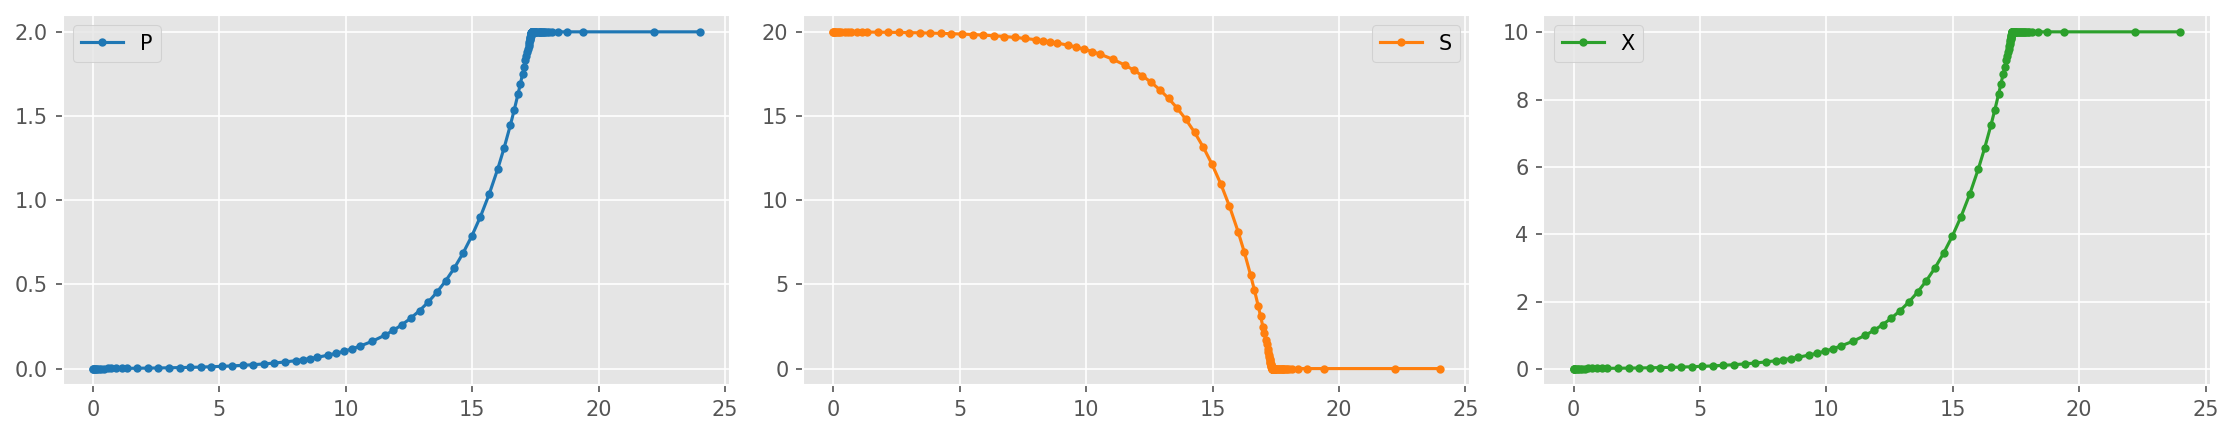

In [5]:
simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation)

# 3. Example: Modelling induction with events

Implements a variant of model 2, which activates product formation (i.e., the corresponding term) at a explicitly defined timepoint (parametrized by `t_ind`).

### Model equations
$$
\begin{align}
    \mu &= \mu_{max} \frac{c_S}{c_S + k_S}\\
    \frac{dc_X}{dt} &= \mu \cdot c_X\\
    \frac{dc_S}{dt} &= -\frac{1}{Y_{X/S}} \cdot \frac{dc_X}{dt} \\
    \frac{dc_P}{dt} &= 
    \begin{cases}
         0 & t < t_{ind}\\
         Y_{P/X} \cdot \frac{dc_X}{dt} & t \ge t_{ind}\\
    \end{cases}\\
    c_X(t_0) &= c_{X,0}\\
    c_S(t_0) &= c_{S,0}\\
    c_P(t_0) &= c_{P,0}\\
\end{align}
$$

### Parametrization
$$
\mathbf{\theta} = \left[ k_S \; \mu_{max} \; Y_{X/S} \; Y_{P/X} \; t_{ind} \; c_{S,0} \; c_{X,0} \; c_{P,0}\right]^T
$$

In [6]:
# Defines the model class
class InductionEvent(BioprocessModel):
    
    # The Monod equation is defined as classmethod
    @classmethod
    def Monod(cls, S, mu_max, kS):
        return mu_max * S / (kS + S)
        
        
    def rhs(self, t, y, sw):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y
        
        # Unpacks the model parameters.
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        YPX = self.model_parameters['YPX']
        YXS = self.model_parameters['YXS']
        
        # Calculate the current growth rate
        mu = self.Monod(S, mu_max, kS)
        
        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -1/YXS * dXdt
        
        if sw[0]:
            dPdt = YPX * dXdt
        else:
            dPdt = 0
        
        return [dPdt, dSdt, dXdt]
    
    
    def state_events(self, t, y, sw):
        t_ind = self.model_parameters['t_ind']
        event_t = t - t_ind
        return [event_t]

    
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.5,
    'YPX' : 0.2,
    't_ind' : 12.0,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}
        
caretaker = Caretaker(
    bioprocess_model_class=InductionEvent, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

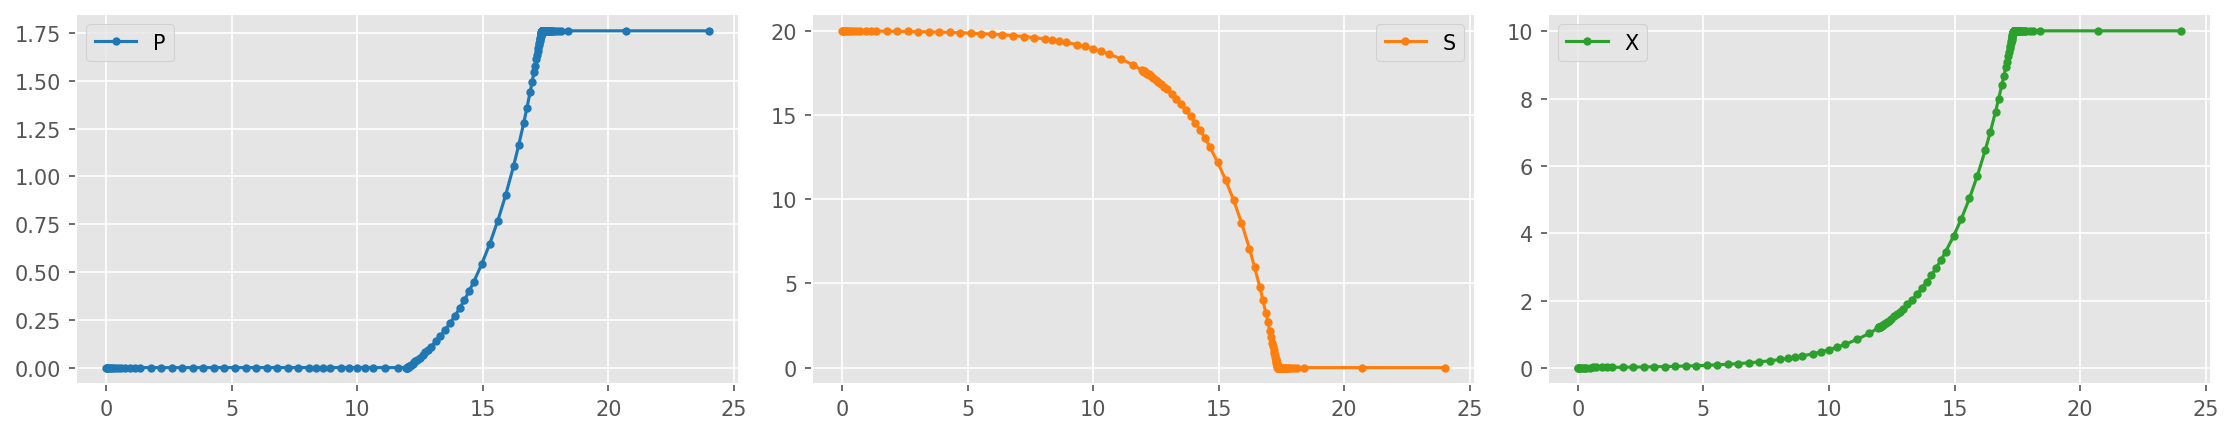

In [7]:
simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation)

# 4. Example: A more complex bioprocess model

This model introduces the use of more complex description of the biological process.

Product formation is induced by the substrate, modelled as a Monod relation.

The growth rate is calculated according to a substrate inhibition, with a rather high inhibition constant meaning that takes severe effect for high substrate concentration. In addtion, the product is modelled as growth inhibitory.

Substrate consumption is composed from substrate needed for biomass formation, as well as needed for product formation. See also Takors R: *Kommentierte Formelsammlung Bioverfahrenstechnik* (2013) p.109

The use of classmethods is also demonstrated: First, they are used to "outsource" calculations during the integration. Second, they are used afterwards to calculate the trajectories of the specific rates from the integrated time series of the model states.

### Model equations

#### Specific rates
$$
\begin{align}
    \mu &= \mu_{max} \cdot \frac{c_S}{c_S + k_S + \frac{c_S^2}{k_{SI}}} \cdot \frac{c_P}{c_P + k_{PI}}\\
    q_P &= q_{P,max} \cdot \frac{c_S}{c_S + k_{SP}}\\
    q_S &= \frac{\mu}{Y_{X/S}} + \frac{q_P}{Y_{P/S}}\\
\end{align}
$$

#### State derivatives
$$
\begin{align}
    \frac{dc_X}{dt} &= \mu \cdot c_X\\
    \frac{dc_S}{dt} &= -q_S \cdot c_X\\
    \frac{dc_P}{dt} &= q_P \cdot c_X\\
\end{align}
$$

#### Initial values
$$
\begin{align}
     c_X(t_0) &= c_{X,0}\\
     c_S(t_0) &= c_{S,0}\\
     c_P(t_0) &= c_{P,0}\\
\end{align}
$$

### Parametrization
$$
\mathbf{\theta} = \left[ k_S \; k_{SI} \; k_{PI} \; \mu_{max} \; q_{P,max} \; k_{SP} \; Y_{X/S} \; Y_{P/S} \; c_{S,0} \; c_{X,0} \; c_{P,0}\right]^T
$$

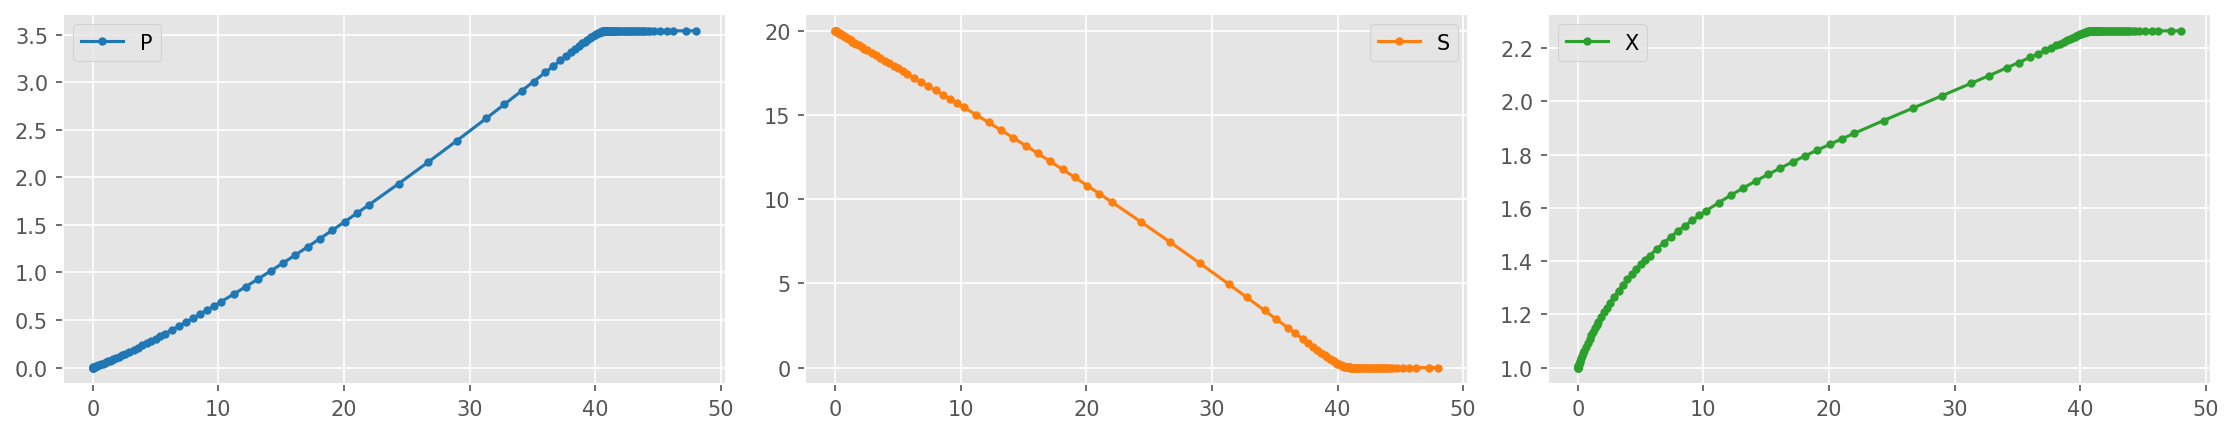

In [8]:
# Defines the model class
class InducingSubstrate(BioprocessModel):
    
    # The Monod equation with the growth-inhibiting product concentration
    @classmethod
    def growth_rate(cls, S, mu_max, kS, kSI, P, kPI):
        return mu_max * S / (kS + S + S**2/kSI) * kPI / (P + kPI)
    
    
    # The cell specific substrate consumption
    @classmethod
    def substrate_consumption(cls, mu, YXS, qP, YPS):
        return mu/YXS + qP/YPS
    
    
    # The cell specific catabolite repressed productivity, modelled as substrate inhibition
    @classmethod
    def product_formation(cls, S, qP_max, kSP):
        return qP_max * S / (kSP + S)
    
    
    def rhs(self, t, y):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y
        
        # Unpacks the model parameters.
        mu_max = self.model_parameters['mu_max']
        kS = self.model_parameters['kS']
        kPI = self.model_parameters['kPI']
        kSI = self.model_parameters['kSI']
        qP_max = self.model_parameters['qP_max']
        kSP = self.model_parameters['kSP']
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        
        # Calculate the current growth rate
        mu = self.growth_rate(S, mu_max, kS, kSI, P, kPI)
        
        # Calculate the current cell specific productivity
        qP = self.product_formation(S, qP_max, kSP)
        
        # Calculate the current cell specific substrate consumption rate
        qS = self.substrate_consumption(mu, YXS, qP, YPS)
        
        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        dPdt = qP * X
        
        return [dPdt, dSdt, dXdt]

    
# Define model parameters and initial values for Caretaker instantiation
model_parameters = {
    'kS' : 0.05,
    'kSP' : 0.1,
    'kSI' : 10.0,
    'kPI' : 0.1,
    'mu_max' : 0.4,
    'YXS' : 0.55,
    'YPS' : 0.2,
    'qP_max' : 0.05,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 1.0,
    'P0' : 0.0,
}
        
# Get Caretaker instance
caretaker = Caretaker(
    bioprocess_model_class=InducingSubstrate, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

# Run a simulation and visualize
simulation = caretaker.simulate(t=48)
_ = Visualization.show_kinetic_data(simulation)

## 4.1. Visualize specific rates (which are no model states) over time

This is where the classmethods come in handy, as mentioned before. The classmethod can be called without the need for an instance of the bioprocess model class, since such instance is handled by the caretaker object.

In [9]:
# Extract necessary trajectory values from the simulation
t = Helpers.extract_time_series(simulation, name='S', replicate_id=None).timepoints
S = Helpers.extract_time_series(simulation, name='S', replicate_id=None).values
P = Helpers.extract_time_series(simulation, name='P', replicate_id=None).values

# Calculate the trajectory of specific growth rate and create a corresponding TimeSeries object 
_mu = InducingSubstrate.growth_rate(
    S, 
    model_parameters['mu_max'], 
    model_parameters['kS'],
    model_parameters['kSI'],
    P,
    model_parameters['kPI'],
)
mu = TimeSeries(name='mu', timepoints=t, values=_mu)

# Calculate the trajectory of biomass specific product formation rate and create a corresponding TimeSeries object 
_qP = InducingSubstrate.product_formation(
    S, 
    model_parameters['qP_max'], 
    model_parameters['kSP'], 
)
qP = TimeSeries(name='qP', timepoints=t, values=_qP)

# Calculate the trajectory of biomass specific substrate formation rate and create a corresponding TimeSeries object 
_qS = InducingSubstrate.substrate_consumption(
    _mu, 
    model_parameters['YXS'], 
    _qP, 
    model_parameters['YPS'],
)
qS = TimeSeries(name='qS', timepoints=t, values=_qS)

# Put the additional TimeSeries objects into a dictonary
specific_rates = [mu, qS, qP]

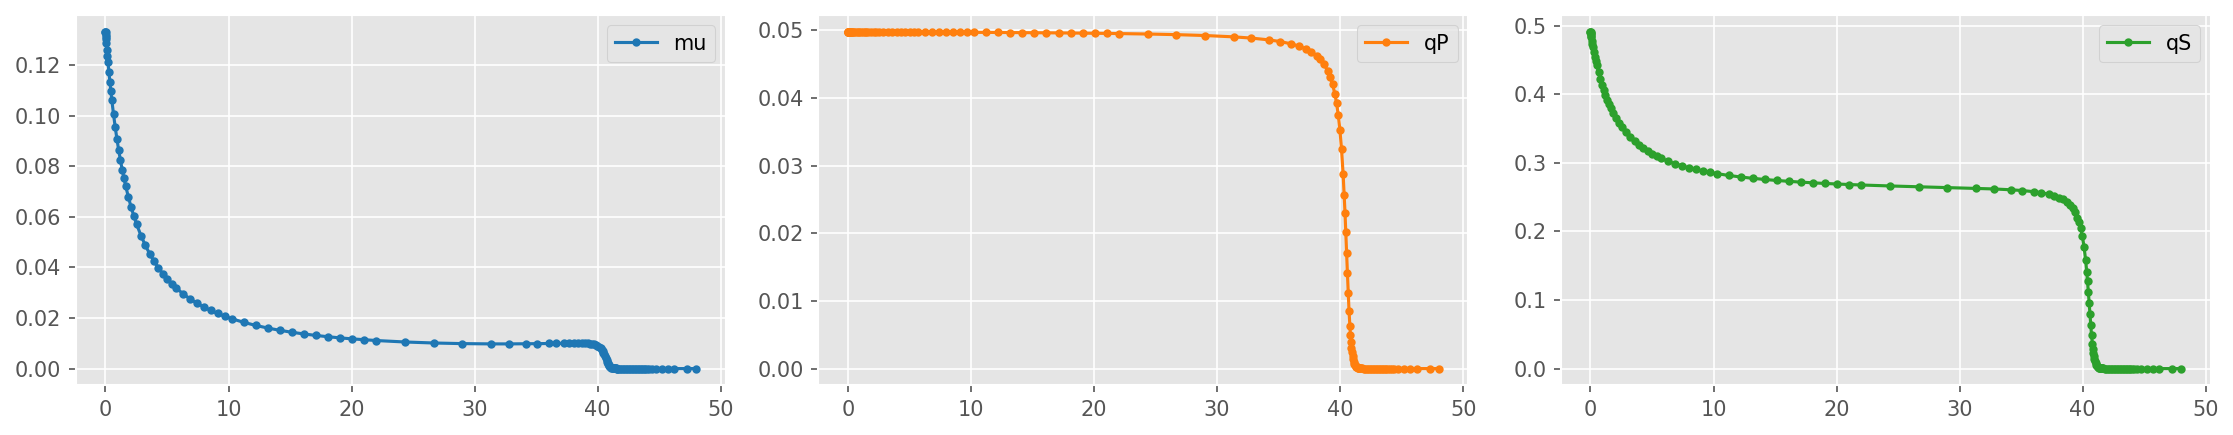

In [10]:
# Have a look at the additional TimeSeries objects
_ = Visualization.show_kinetic_data(specific_rates)

## 4.2. What can be done further, what purpose may serve the model?
__Get an idea on the functional relationship between initial substrate concentration $S_0$ and maximum Space-Time-Yield $STY_{max}$__

For each bioprocess that is run, the Space-Time-Yield over time has an optimium (maximum). This optimium varies, among others, with the initial substrate concentration $S_0$. The model can now be run for a variation of $S_0$ values, and for each variation the value of $STY_{max}$ can be calculated.

In [11]:
variation_S0 = numpy.linspace(0, 100, 1000)
# Choose a final simulation time that allows for complete substrate consumption for all variants
t_final = 480
STYmax = []
for S0 in variation_S0:
    # Runs a simulation for each S0
    _simulation = caretaker.simulate(t=t_final, parameters={'S0' : S0})
    # Calculate the corresponding trajectory of STY
    _t = Helpers.extract_time_series(_simulation, name='P', replicate_id=None).timepoints[1:] # omit first timepoint 0 to avoid zero division error
    _P = Helpers.extract_time_series(_simulation, name='P', replicate_id=None).values[1:]
    _STY = _P / _t
    # Get the maximum STY for this simulation
    STYmax.append(numpy.nanmax(_STY))
STYmax = numpy.array(STYmax)

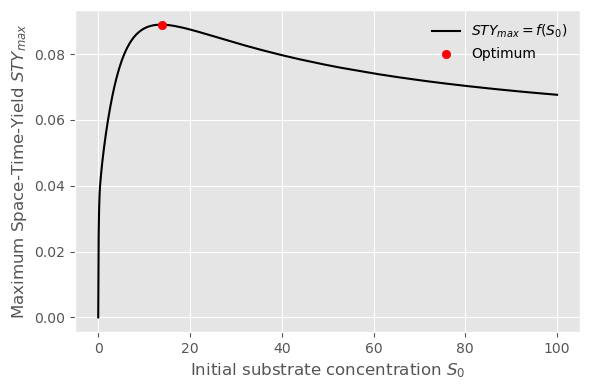

In [12]:
# Visualize the results
fig, ax = pyplot.subplots(dpi=100)
ax.plot(variation_S0, STYmax, linestyle='-', marker='', color='black', zorder=1, label='$STY_{max} = f\\left(S_0\\right)$')
_max_idx = numpy.argmax(STYmax)
ax.scatter(variation_S0[_max_idx], STYmax[_max_idx], zorder=2, color='red', label='Optimum')
ax.set_xlabel('Initial substrate concentration $S_0$')
ax.set_ylabel('Maximum Space-Time-Yield $STY_{max}$')
ax.legend(frameon=False)
fig.tight_layout()

# 5. Example: Two-substrates growth,  one acting as inducer and inhibitor

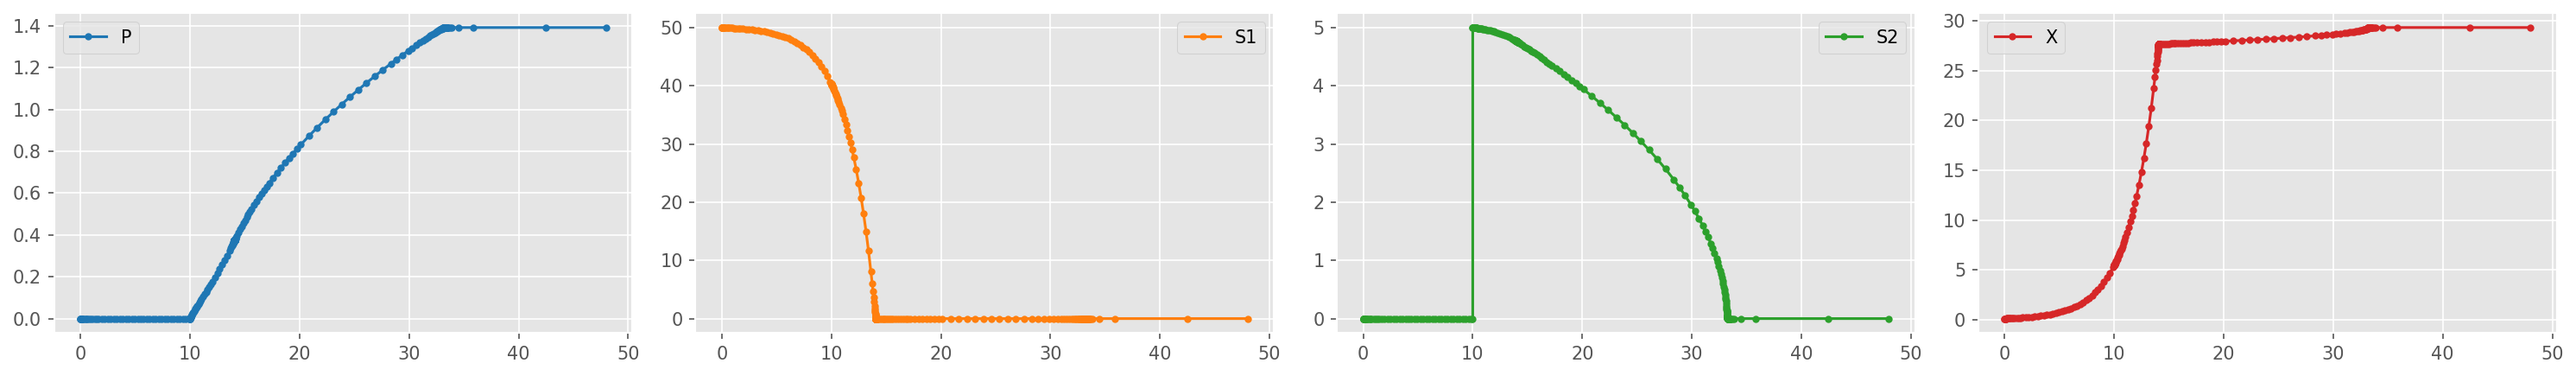

In [13]:
# Defines the model class
class TwoSubstrateGrowth(BioprocessModel):
    
    # The Monod equation is defined as classmethod
    @classmethod
    def Monod(cls, S, mu_max, kS):
        return mu_max * S / (kS + S)
    
    
    @classmethod
    def substrate_inhibition(cls, S, mu_max, kS, kI):
        return mu_max * S / (kS + S + S**2/kI)
    
    
    @classmethod
    def product_formation(cls, S, qP_max, kSP, P, kPI):
        return qP_max * S / (kSP + S) * kPI/(kPI + P)
        
        
    def rhs(self, t, y, sw):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S1, S2, X = y
        
        # Unpacks the model parameters.
        kS1 = self.model_parameters['kS1']
        mu_max1 = self.model_parameters['mu_max1']
        YXS1 = self.model_parameters['YXS1']
        
        kS2 = self.model_parameters['kS2']
        kS2I = self.model_parameters['kS2I']
        mu_max2 = self.model_parameters['mu_max2']
        YXS2 = self.model_parameters['YXS2']
        
        qP_max = self.model_parameters['qP_max']
        kSP = self.model_parameters['kSP']
        kPI = self.model_parameters['kPI']

        # Calculate specific growth rate
        mu1 = self.Monod(S1, mu_max1, kS1)
        mu2 = self.substrate_inhibition(S2, mu_max2, kS2, kS2I)
        mu = mu1 + mu2
        
        # Calculate substrate consumption rates.
        qS1 = 1/YXS1*mu1
        qS2 = 1/YXS2*mu2

        # Calculate product formation rate.
        qP = self.product_formation(S2, qP_max, kSP, P, kPI)
        
        # Calculate state derivatives.
        dXdt = mu*X
        dS1dt = -qS1*X
        dS2dt = -qS2*X
        dPdt = qP*X
        
        # Return list of state derivatives in the same order as the state vector was unpacked.
        return [dPdt, dS1dt, dS2dt, dXdt]

    
    def state_events(self, t, y, sw):
        t_add = self.model_parameters['t_add']
        event_t = t - t_add
        return [event_t]
    
    
    def change_states(self, t, y, sw):
        P, S1, S2, X = y
        S2_add = self.model_parameters['S2_add']
        if sw[0]:
            S2 = S2 + S2_add
        return [P, S1, S2, X]
        

model_parameters = {
    'kS1' : 0.02,
    'mu_max1' : 0.4,
    'YXS1' : 0.55,
    'kS2' : 0.2,
    'kS2I' : 0.05,
    'mu_max2' : 0.15,
    'YXS2' : 0.35,
    'qP_max' : 0.02,
    'kSP' : 0.2,
    'kPI' : 0.1,
    't_add' : 10.0,
    'S2_add' : 5.0,
}     

initial_values = {
    'S10' : 50.0,
    'S20' : 0.0,
    'P0' : 0.0,
    'X0' : 0.1,
}
        
caretaker = Caretaker(
    bioprocess_model_class=TwoSubstrateGrowth, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

simulation = caretaker.simulate(t=48)
_ = Visualization.show_kinetic_data(simulation, ncols=4)